In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformers import Trainer, TrainingArguments, set_seed

from tsfm_public import TimeSeriesPreprocessor, get_datasets
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.visualization import plot_predictions

import warnings
warnings.filterwarnings("ignore")

# Set seed for reproducibility
SEED = 42
set_seed(SEED)

print("="*70)
print("MULTI-SESSION VEHICLE FORECASTING WITH TTM")
print("="*70)

MULTI-SESSION VEHICLE FORECASTING WITH TTM


In [2]:
#import os, types
#import pandas as pd
#from botocore.client import Config
#import ibm_boto3

# def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

#cos_client = ibm_boto3.client(service_name='s3',
#    ibm_api_key_id='g75Lu6JFR1y-6Gi0McIzx5Z6BJKcK9MB45s1wYETrsWa',
#    ibm_auth_endpoint="https://iam.cloud.ibm.com/identity/token",
#    config=Config(signature_version='oauth'),
#    endpoint_url='https://s3.direct.eu-gb.cloud-object-storage.appdomain.cloud')

#bucket = 'darenssandbox-donotdelete-pr-9znbpopeprchps'
#object_key = 'combined_obd_dataset_watsonx.csv'

#body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
## add missing __iter__ method, so pandas accepts body as file-like object
#if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

### 1. Load Combined WatsonX Dataset
#data = pd.read_csv(body)

In [4]:
dataset_path = "/Users/darenpalmer/Desktop/UCL/CS/fyp/data/dataset/combined_obd_dataset_watsonx.csv"
print(f"\nLoading combined dataset from: {dataset_path}")
data = pd.read_csv(dataset_path, parse_dates=["timestamp"])


Loading combined dataset from: /Users/darenpalmer/Desktop/UCL/CS/fyp/data/dataset/combined_obd_dataset_watsonx.csv


In [6]:

print(f"✓ Loaded: {len(data):,} total samples")
print(f"✓ Columns: {len(data.columns)}")

# Preview
print(f"\nDataset preview:")
print(data[['timestamp', 'source_file', 'original_row_id', 'Vehicle Speed Sensor [km/h]']].head(10))

✓ Loaded: 2,693,087 total samples
✓ Columns: 23

Dataset preview:
                timestamp                         source_file  \
0 2017-07-05 07:16:31.257  2017-07-05_Seat_Leon_RT_S_Stau.csv   
1 2017-07-05 07:16:31.345  2017-07-05_Seat_Leon_RT_S_Stau.csv   
2 2017-07-05 07:16:31.435  2017-07-05_Seat_Leon_RT_S_Stau.csv   
3 2017-07-05 07:16:31.525  2017-07-05_Seat_Leon_RT_S_Stau.csv   
4 2017-07-05 07:16:31.615  2017-07-05_Seat_Leon_RT_S_Stau.csv   
5 2017-07-05 07:16:31.705  2017-07-05_Seat_Leon_RT_S_Stau.csv   
6 2017-07-05 07:16:31.795  2017-07-05_Seat_Leon_RT_S_Stau.csv   
7 2017-07-05 07:16:31.886  2017-07-05_Seat_Leon_RT_S_Stau.csv   
8 2017-07-05 07:16:31.975  2017-07-05_Seat_Leon_RT_S_Stau.csv   
9 2017-07-05 07:16:32.065  2017-07-05_Seat_Leon_RT_S_Stau.csv   

   original_row_id  Vehicle Speed Sensor [km/h]  
0                0                          0.0  
1                1                          0.0  
2                2                          0.0  
3                3

In [7]:
## 2. Choose Which Columns to Track

target_columns = [
    "Vehicle Speed Sensor [km/h]",
    "Engine RPM [RPM]",
]

print(f"\n✓ Tracking {len(target_columns)} columns:")
for col in target_columns:
    print(f"    - {col}")

## 3. Add Numeric Session ID for TTM
# Create a numeric session_id from source_file
# TTM works better with numeric IDs since it treats each recorded session separately
source_files = data['source_file'].unique()
file_to_id = {file: idx for idx, file in enumerate(source_files)}
data['session_id'] = data['source_file'].map(file_to_id)

print(f"\n✓ Created session_id mapping:")
print(f"  Total sessions: {data['session_id'].nunique()}")
print(f"  Example: '{source_files[0]}' → session_id = 0")


✓ Tracking 2 columns:
    - Vehicle Speed Sensor [km/h]
    - Engine RPM [RPM]

✓ Created session_id mapping:
  Total sessions: 81
  Example: '2017-07-05_Seat_Leon_RT_S_Stau.csv' → session_id = 0



Visualizing sample sessions...
✓ Sample sessions plot saved to plots/sample_sessions.png


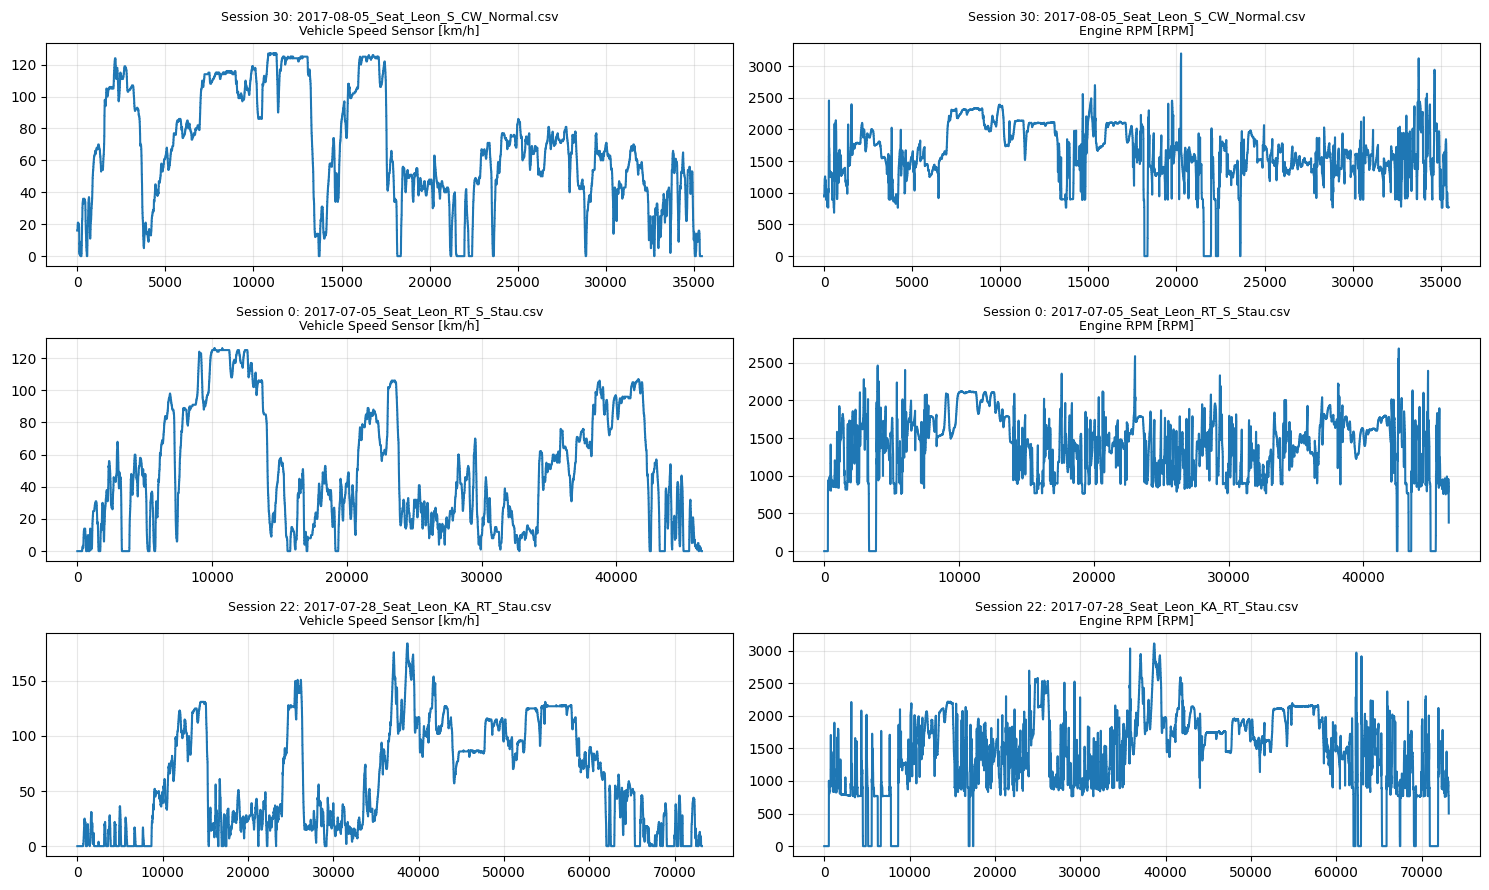

In [8]:
## 4. Visualize Sample Sessions

# Define the directory and filename
dir_path = 'plots'
file_name = 'sample_sessions.png'
full_path = os.path.join(dir_path, file_name)

# Create the directory if it does not exist
os.makedirs(dir_path, exist_ok=True)


print("\nVisualizing sample sessions...")
num_sessions_to_plot = 3
np.random.seed(SEED)
sample_session_ids = np.random.choice(data['session_id'].unique(), num_sessions_to_plot, replace=False)

fig, axes = plt.subplots(num_sessions_to_plot, len(target_columns), figsize=(15, 3*num_sessions_to_plot))

if num_sessions_to_plot == 1:
    axes = axes.reshape(1, -1)

for row, sess_id in enumerate(sample_session_ids):
    session_data = data[data['session_id'] == sess_id]
    session_name = session_data['source_file'].iloc[0]
    
    for col_idx, col in enumerate(target_columns):
        ax = axes[row, col_idx] if len(target_columns) > 1 else axes[row]
        ax.plot(session_data[col].values)
        ax.set_title(f'Session {sess_id}: {session_name}\n{col}', fontsize=9)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(full_path, dpi=150, bbox_inches='tight')
print(f"✓ Sample sessions plot saved to {full_path}")

In [9]:
## 5. Configure TTM with Multi-Series Support

# CRITICAL: Use session_id as the ID column
# This tells TTM that each session is a separate time series
timestamp_column = "timestamp"
id_columns = ["session_id"]  # ← This is the key!

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,  # TTM will respect session boundaries
    "target_columns": target_columns,
    "control_columns": [],
}

# Model configuration
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
CONTEXT_LENGTH = 512
PREDICTION_LENGTH = 96
print(f"\n{'='*70}")
print(f"MODEL CONFIGURATION")
print(f"{'='*70}")
print(f"Model: {TTM_MODEL_PATH}")
print(f"Context Length: {CONTEXT_LENGTH} time points")
print(f"Prediction Length: {PREDICTION_LENGTH} time points")
print(f"ID Column: {id_columns[0]} (ensures sessions don't mix)")


MODEL CONFIGURATION
Model: ibm-granite/granite-timeseries-ttm-r2
Context Length: 512 time points
Prediction Length: 96 time points
ID Column: session_id (ensures sessions don't mix)


In [10]:

## 6. Prepare Data

print(f"\nPreparing data...")

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

# Split configuration - splits WITHIN each session
# Each session gets split 70/15/15, but sessions never mix
split_config = {
    "train": [0, 0.7],     # First 70% of each session
    "valid": [0.7, 0.85],  # Next 15% of each session
    "test": [0.85, 1.0],   # Last 15% of each session
}

print("Loading pre-trained TTM model...")
model = get_model(
    TTM_MODEL_PATH,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
)

# Create datasets - samples from ALL sessions
print("Creating train/valid/test datasets...")
dset_train, dset_valid, dset_test = get_datasets(
    tsp,
    data,
    split_config,
    use_frequency_token=model.config.resolution_prefix_tuning
)

print(f"\n✓ Dataset sizes:")
print(f"    Train: {len(dset_train):,} samples")
print(f"    Valid: {len(dset_valid):,} samples")
print(f"    Test:  {len(dset_test):,} samples")

# Calculate samples per session (approximate)
avg_session_length = len(data) / data['session_id'].nunique()
approx_samples_per_session = (avg_session_length * 0.7 - CONTEXT_LENGTH) / PREDICTION_LENGTH
print(f"\n  Approx {approx_samples_per_session:.0f} training samples per session")
print(f"  From {data['session_id'].nunique()} sessions")

INFO:p-16526:t-8439422720:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2



Preparing data...
Loading pre-trained TTM model...


INFO:p-16526:t-8439422720:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-16526:t-8439422720:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Creating train/valid/test datasets...

✓ Dataset sizes:
    Train: 1,835,954 samples
    Valid: 396,267 samples
    Test:  396,309 samples

  Approx 237 training samples per session
  From 81 sessions


In [11]:
## 7. Zero-Shot Evaluation

print(f"\n{'='*70}")
print(f"ZERO-SHOT EVALUATION (No Fine-Tuning)")
print(f"{'='*70}")

trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir="./output",
        per_device_eval_batch_size=64,
        seed=SEED,
        report_to="none",
    ),
)

print("Evaluating on test set...")
results = trainer.evaluate(dset_test)
print(f"\n✓ Test MSE: {results['eval_loss']:.4f}")

print("\nGenerating predictions...")
predictions = trainer.predict(dset_test)
predictions_np = predictions.predictions[0]
print(f"✓ Predictions shape: {predictions_np.shape}")
print(f"  ({predictions_np.shape[0]} samples × {predictions_np.shape[1]} timesteps × {predictions_np.shape[2]} channels)")

## 8. Visualize Predictions

print(f"\n{'='*70}")
print(f"VISUALIZATION")
print(f"{'='*70}")

os.makedirs("./plots", exist_ok=True)

# Select random examples to plot
num_examples = 8
np.random.seed(SEED)
example_indices = np.random.choice(len(dset_test), size=num_examples, replace=False)

print(f"\nPlotting {num_examples} random examples for each channel...")

# Plot each channel
for channel_idx, channel_name in enumerate(target_columns):
    print(f"  Channel {channel_idx}: {channel_name}")
    
    plot_predictions(
        model=model,
        dset=dset_test,
        plot_dir="./plots",
        plot_prefix=f"watsonx_predictions",
        indices=example_indices.tolist(),
        channel=channel_idx,
    )

print(f"\n✓ Plots saved to ./plots/watsonx_predictions_ch_*.pdf")


ZERO-SHOT EVALUATION (No Fine-Tuning)
Evaluating on test set...



✓ Test MSE: 0.3261

Generating predictions...


RuntimeError: MPS backend out of memory (MPS allocated: 17.36 GiB, other allocations: 2.72 MiB, max allowed: 18.13 GiB). Tried to allocate 795.50 MiB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
## 9. Analyze by Driving Condition

print(f"\n{'='*70}")
print(f"ANALYSIS BY DRIVING CONDITION")
print(f"{'='*70}")

# Extract condition from source_file
def extract_condition(filename):
    """Extract driving condition from filename"""
    if 'Stau' in filename:
        return 'Traffic Jam'
    elif 'Frei' in filename:
        return 'Free Flow'
    elif 'Normal' in filename:
        return 'Normal'
    elif 'Glatteis' in filename:
        return 'Ice'
    elif 'Vollbremsung' in filename:
        return 'Emergency Brake'
    else:
        return 'Other'

data['condition'] = data['source_file'].apply(extract_condition)

# Sessions by condition
condition_counts = data.groupby('condition')['session_id'].nunique()
print("\nSessions by condition:")
for condition, count in sorted(condition_counts.items(), key=lambda x: x[1], reverse=True):
    pct = 100 * count / data['session_id'].nunique()
    print(f"  {condition:20s}: {count:2d} sessions ({pct:.1f}%)")

# Speed statistics by condition
print("\nSpeed statistics by condition:")
speed_stats = data.groupby('condition')['Vehicle Speed Sensor [km/h]'].agg(['mean', 'std', 'max'])
print(speed_stats.round(2))

## 10. Summary

print(f"\n{'='*70}")
print(f"SUMMARY")
print(f"{'='*70}")
print(f"Dataset:")
print(f"  ✓ {len(data):,} total samples")
print(f"  ✓ {data['session_id'].nunique()} driving sessions")
print(f"  ✓ {len(target_columns)} tracked columns")
print(f"\nModel:")
print(f"  ✓ Context: {CONTEXT_LENGTH} points")
print(f"  ✓ Prediction: {PREDICTION_LENGTH} points")
print(f"  ✓ Sessions separated by ID column: '{id_columns[0]}'")
print(f"\nResults:")
print(f"  ✓ Train samples: {len(dset_train):,}")
print(f"  ✓ Valid samples: {len(dset_valid):,}")
print(f"  ✓ Test samples: {len(dset_test):,}")
print(f"  ✓ Zero-shot MSE: {results['eval_loss']:.4f}")
print(f"\nKey Feature:")
print(f"  • Model treats each of {data['session_id'].nunique()} sessions separately")
print(f"  • Samples NEVER cross session boundaries")
print(f"  • Learns patterns from diverse driving conditions")
print(f"\nNext Steps:")
print(f"  • Fine-tune the model on this dataset for better performance")
print(f"  • Evaluate performance per driving condition")
print(f"  • Try different context/prediction lengths")
print(f"  • Add more target columns to track")
print(f"{'='*70}")
